In [1]:
import tensorflow as tf
import pathlib
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential

AUTOTUNE = tf.data.experimental.AUTOTUNE

<font size=5>
Dataset

In [2]:
train_root = pathlib.Path(r'C:\Users\Wreathmoon\Desktop\train_dataset')
val_root = pathlib.Path(r'C:\Users\Wreathmoon\Desktop\val_dataset')

In [3]:
import random

train_paths = list(train_root.glob('*/*'))
train_paths = [str(path) for path in train_paths]
random.shuffle(train_paths)

val_paths = list(val_root.glob('*/*'))
val_paths = [str(path) for path in val_paths]
random.shuffle(val_paths)

train_count = len(train_paths)
val_count = len(val_paths)
print(train_count,val_count)

888 111


In [4]:
train_label_names = sorted(item.name for item in train_root.glob('*/') if item.is_dir())
val_label_names = sorted(item.name for item in val_root.glob('*/') if item.is_dir())

train_label_to_index = dict((name, index) for index, name in enumerate(train_label_names))
val_label_to_index = dict((name, index) for index, name in enumerate(val_label_names))

train_label_to_index

{'cube': 0, 'cylinder': 1, 'sphere': 2}

In [5]:
train_labels = [train_label_to_index[pathlib.Path(path).parent.name]
                    for path in train_paths]
val_labels = [val_label_to_index[pathlib.Path(path).parent.name]
                    for path in val_paths]

print("First 10 labels indices: ", train_labels[:10])
print("First 10 labels indices: ", val_labels[:10])

First 10 labels indices:  [1, 0, 1, 1, 0, 1, 1, 1, 1, 2]
First 10 labels indices:  [0, 0, 2, 1, 2, 1, 2, 2, 0, 1]


In [6]:
def preprocess_3dmodels(path):
    n_points=50
    step_size=1
    data = np.genfromtxt(path)
    # create canvas cube with all 0s
    cube = np.zeros((n_points,n_points,n_points))
    # use step size to see how big is a voxel
    factor = 1/step_size
    # calculate center of the cube, which relates to 0,0,0 in xyz
    center = n_points//2
 
    for entry in data:
        x, y, z = entry
        x=int(x*factor+center)
        y=int(y*factor+center)
        z=int(z*factor+center)
        # adjust coordinates to cube
        cube[x, y, z] = cube[x, y, z]+1
 
    return cube

In [7]:
def load_and_preprocess_3dmodels(list):
    i=0
    value = [None] * len(list)    
    while i<len(list):
        value[i] =  preprocess_3dmodels(list[i])
        i+=1
    
    return value

In [8]:
train_values = load_and_preprocess_3dmodels(train_paths)
val_values = load_and_preprocess_3dmodels(val_paths)

train_values = tf.expand_dims(train_values, axis=-1)
val_values = tf.expand_dims(val_values, axis=-1)

In [9]:
train_labels = tf.expand_dims(train_labels, axis=-1)
val_labels = tf.expand_dims(val_labels, axis=-1)

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_values, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_values, val_labels))
val_ds

<TensorSliceDataset shapes: ((50, 50, 50, 1), (1,)), types: (tf.float64, tf.int32)>

In [11]:
BATCH_SIZE = 32

train_ds = train_ds.shuffle(buffer_size=train_count)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = train_ds.shuffle(buffer_size=val_count)
val_ds = train_ds.batch(BATCH_SIZE)
val_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

train_ds 

<PrefetchDataset shapes: ((None, 50, 50, 50, 1), (None, 1)), types: (tf.float64, tf.int32)>

<font size=5>
Model

In [12]:
num_class = 3

model = Sequential([
    layers.Conv3D(32, 5, padding='valid', strides=(2,2,2), activation='relu', input_shape=(50, 50, 50, 1)),
    layers.Dropout(0.4),
    layers.Conv3D(32, 3, padding='valid', strides=(2,2,2), activation='relu'),
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_class)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 23, 23, 23, 32)    4032      
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 23, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 11, 11, 11, 32)    27680     
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 11, 32)    0         
_________________________________________________________________
flatten (Flatten)            (None, 42592)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1362976   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

<font size=5>
Training

In [14]:
epochs = 5
history = model.fit(train_ds, epochs=epochs, verbose=1, validation_data=val_ds)

Epoch 1/5
28/28 [==============================] - 9s 319ms/step - loss: 0.5229 - accuracy: 0.7725 - val_loss: 0.0659 - val_accuracy: 0.9966
Epoch 2/5
28/28 [==============================] - 9s 311ms/step - loss: 0.0731 - accuracy: 0.9786 - val_loss: 0.0267 - val_accuracy: 0.9932
Epoch 3/5
28/28 [==============================] - 9s 327ms/step - loss: 0.0571 - accuracy: 0.9786 - val_loss: 0.0129 - val_accuracy: 0.9989
Epoch 4/5
28/28 [==============================] - 9s 319ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 5/5
28/28 [==============================] - 9s 316ms/step - loss: 0.0364 - accuracy: 0.9899 - val_loss: 0.0039 - val_accuracy: 1.0000


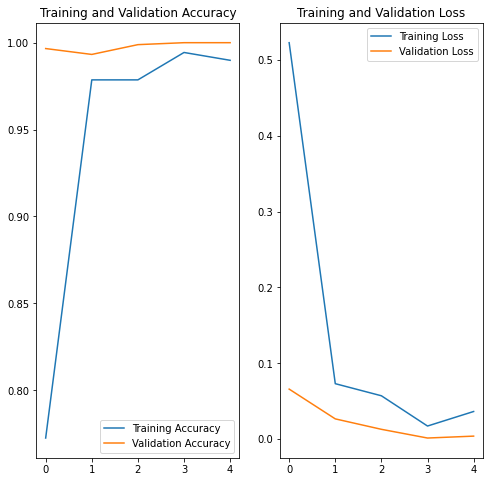

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
class_names = train_label_names
predict = preprocess_3dmodels(r'C:\Users\Wreathmoon\Desktop\Prediction_data\cylinder.xyz')

p_array = tf.expand_dims(predict, 0) # Create a batch
p_array = tf.expand_dims(p_array, -1)
predictions = model.predict(p_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to cylinder with a 99.94 percent confidence.
